# 1.1 Clusters with age below 500 Myrs

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from sklearn.neighbors import NearestNeighbors
import scipy as sp
from scipy.spatial import distance
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_scatter_density 
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings('ignore')

# Functions

In [3]:
def preprocess_cluster(data, g_mean_th=18):
    """
    ------
    parallax > 0 

    phot_g_mean_mag < g_mean_th
    ------
    """
    data = data[data['parallax'] > 0]
    data = data[data['phot_g_mean_mag'] < g_mean_th]
    data['Gmg'] = data['phot_g_mean_mag'] + (5 * np.log10(data['parallax']) - 10)
    data['L'] = 10**(0.4*(4.83 - data['Gmg']))
    print(len(data))
    return data


def cmd_plot(data, x_axis, y_axis, alpha=0.8, s=5):
    """
    -------
    plot isochrone
    -------
    """

    with plt.style.context(['ieee']):
        fig = plt.figure(figsize=(6,6), dpi=100)
        sns.scatterplot(data=data, y=y_axis, x=x_axis, alpha=alpha, s=s)
        plt.gca().invert_yaxis();
        
        
def joint_plot(data):

    plt.figure(dpi=90)
    sns.jointplot(
        data=data,
        x="pmra", y="pmdec",
        kind="kde"
        );
    
    
def fit_curve(data, column, bins = 100):

    plt.figure(figsize=(12,3), dpi=120)
    counts, bins, patches = plt.hist(data[column], bins = bins)

    # Define the Gaussian function
    def gaussian(x, amp, mu, sigma):
        return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    
    # data
    x_data = bins[:-1]
    y_data = counts
    
    # Fit the Gaussian function to the data
    popt, pcov = curve_fit(gaussian, x_data, y_data)
    
    plt.figure(figsize=(12,3), dpi=120)
    # Plot the original data and the fitted curve
    sns.scatterplot(x_data, y_data, label=column)
    plt.plot(x_data, gaussian(x_data, *popt), color='red', label='Fit')
    plt.legend()
    plt.show()
    
    return popt


def guassian_filter(data, column, mu, std):    
    up = round(mu + 3 * std, 2)
    low = round(mu - 3 * std, 2)
    
    if up > low:
        print('upper bound:', up) 
        print('lower bound:', low)
        df = data[(data[column] < up) & (data[column] > low)]
    else:
        print('upper bound:', low) 
        print('lower bound:', up)
        df = data[(data[column]< low) & (data[column] > up)]
    
    print('cluster length:', len(df))
    return df


def luminosity_density(cluster_3d, clusterdf):
    """
    --------
    cluster_3d --> measuring distance in that dataframe
    
    clusterdf --> main dataframe
    -------
    """
    # create a NearestNeighbors object and fit the dataset
    nbrs = NearestNeighbors(n_neighbors=6, metric='minkowski').fit(cluster_3d)

    # find the 5 nearest neighbors for each data point including itself
    distances, indices = nbrs.kneighbors(cluster_3d)

    # find maximum distance among 5 neighbors
    max_distances = np.amax(distances, axis=1)

    # sphere of that max distance
    spheres = (4/3) * np.pi * (max_distances ** 3)

    # sum of luminosities of each 6 nn
    lum_sum = []
    for i in range(len(clusterdf)):
        lum_sum.append(np.sum(clusterdf.iloc[indices[i]]['L']))

    # luminosity density
    lum_dens = lum_sum / spheres

    return lum_dens



def lum_plot(data):
    """
    --------
    plot for luminosity density profile
    --------
    """    
    
    with plt.style.context(['ieee']):
        plt.figure(figsize=(12,6), dpi=200)
        plt.plot(range(len(data)), np.sort(data))
        plt.ylabel('ΔL/ΔV')
        plt.title('luminosity density profile');

### Open cluster names

In [6]:
x

Int64Index([ 17, 169, 177, 179, 182, 187, 188, 190, 191, 193, 194, 209, 210,
            220, 318, 390, 424, 460, 517, 560, 600, 739, 742, 745, 825, 876,
            886, 887],
           dtype='int64')

In [8]:
open_clusters[(10**open_clusters['logt'] < 4 * 10**9) & (10**open_clusters['logt'] >= 2 * 10**9)]

,Name,RA,DEC,l,b,d,EBV,logt,D,ad2k,...,gen,wal,vil,wbvr,ddo,cmt,jhk,dapeo,daccd,byha
17,Arp-Madore 2,07 38 46,-33 50 36,248.13,-5.88,13341,0.57,9.335,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
169,Berkeley 8,02 01 06,+75 29 00,127.35,13.21,3150,0.75,9.500,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177,Berkeley 19,05 24 06,+29 36 00,176.9,-3.59,4831,0.4,9.490,4,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179,Berkeley 21,05 51 42,+21 47 00,186.84,-2.51,5000,0.76,9.340,5,1567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182,Berkeley 25,06 41 16,-16 29 12,226.61,-9.69,11300,0.17,9.600,2,644,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187,Berkeley 31,06 57 36,+08 16 00,206.25,5.12,8272,0.08,9.313,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
188,Berkeley 32,06 58 06,+06 26 00,207.95,4.4,3100,0.16,9.530,6,19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,Berkeley 34,07 00 24,+00 15 00,213.73,2.11,7280,0.45,9.450,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,Berkeley 36,07 16 06,-13 06 00,227.38,-0.59,6140,0.4,9.500,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193,Berkeley 42,19 05 06,+01 53 00,36.17,-2.18,1826,0.76,9.325,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
open_clusters = pd.read_excel('../../data/open clusters table.xlsx')

open_clusters = open_clusters.dropna(axis=0, subset=['Name', 'logt']).drop(index=0)
open_clusters['logt'] = open_clusters.logt.astype(float)

x = open_clusters[(10**open_clusters['logt'] < 4 * 10**9) & (10**open_clusters['logt'] >= 2 * 10**9)].index
open_clusters.iloc[x].dropna(axis=1)

,Name,RA,DEC,l,b,d,EBV,logt,D
18,ASCC 1,00 09 35,+62 40 48,118.15,0.19,4000,0.16,8.250,24
172,Berkeley 12,04 44 36,+42 41 00,161.67,-1.99,3162,0.7,9.670,4
180,Berkeley 22,05 58 24,+07 50 00,199.88,-8.08,7663,0.7,9.027,1
182,Berkeley 25,06 41 16,-16 29 12,226.61,-9.69,11300,0.17,9.600,2
185,Berkeley 29,06 53 18,+16 55 00,197.98,8.02,14871,0.157,9.025,6
190,Berkeley 34,07 00 24,+00 15 00,213.73,2.11,7280,0.45,9.450,2
191,Berkeley 36,07 16 06,-13 06 00,227.38,-0.59,6140,0.4,9.500,5
193,Berkeley 42,19 05 06,+01 53 00,36.17,-2.18,1826,0.76,9.325,5
194,Berkeley 54,21 03 12,+40 28 00,83.13,-4.14,2300,0.77,9.600,4
197,Berkeley 58,00 00 12,+60 58 00,116.75,-1.29,3715,0.55,8.400,5


## NGC 4337 (200 Myr)

In [13]:
df_NGC_4337 = pd.read_csv('../../data/NGC 4337-result.csv')

In [14]:
df_NGC_4337 = preprocess_cluster(df_NGC_4337, g_mean_th=18)

2149


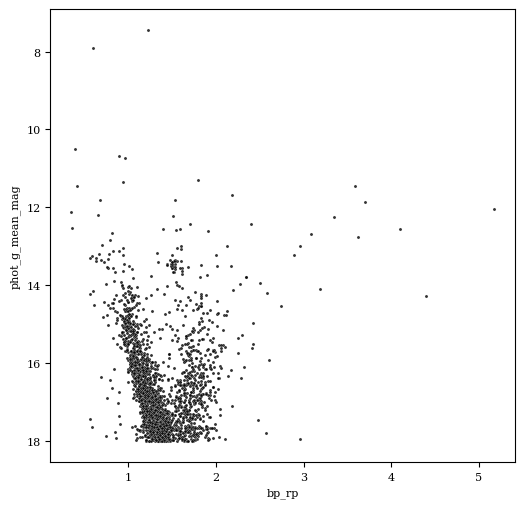

In [15]:
cmd_plot(df_NGC_4337, 'bp_rp', 'phot_g_mean_mag')

In [52]:
df_NGC_4337_new = df_NGC_4337.drop(['phot_variable_flag', 'source_id', 'l', 'b', 'dec_error', 'parallax_error', 
                            'bp_g', 'ra_error', 'radial_velocity', 'radial_velocity_error'],
                          axis=1).dropna(axis=0)
len(df_NGC_4337_new)

2124

<Figure size 540x360 with 0 Axes>

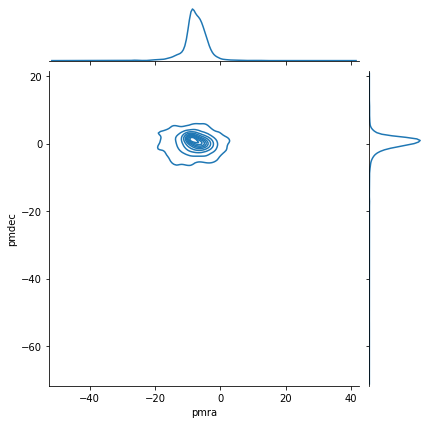

In [20]:
joint_plot(df_NGC_4337_new);

In [53]:
# Initial Filter on PMRA and PMDEC based on joint plot
df_NGC_4337_new = df_NGC_4337_new[abs(df_NGC_4337_new['pmra']) < 20]
df_NGC_4337_new = df_NGC_4337_new[abs(df_NGC_4337_new['pmdec']) < 20]
len(df_NGC_4337_new)

2096

<Figure size 540x360 with 0 Axes>

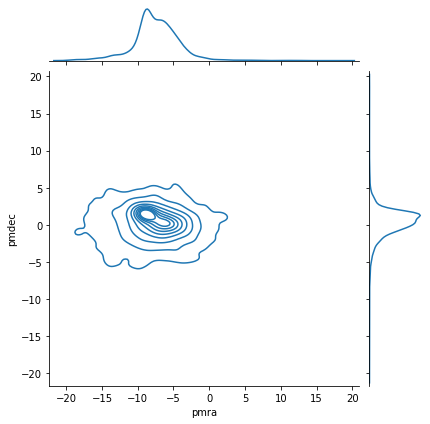

In [22]:
joint_plot(df_NGC_4337_new);

------


# 2

## 2.1 Filters 

**NGC 4337:**  

Proper motions mas/yr based on [SIMBAD](https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=NGC+4337&submit=SIMBAD+search):	
```python
    pmra:  -8.841 
    pmdec:  1.468
```

In [58]:
df_NGC_4337_new = df_NGC_4337_new[abs(df_NGC_4337_new['pmdec'] - 1.5) < 0.75]
len(df_NGC_4337_new)

740

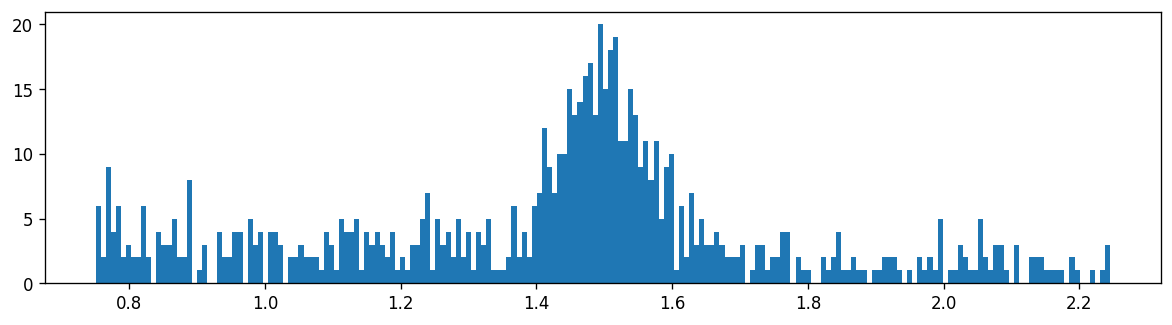

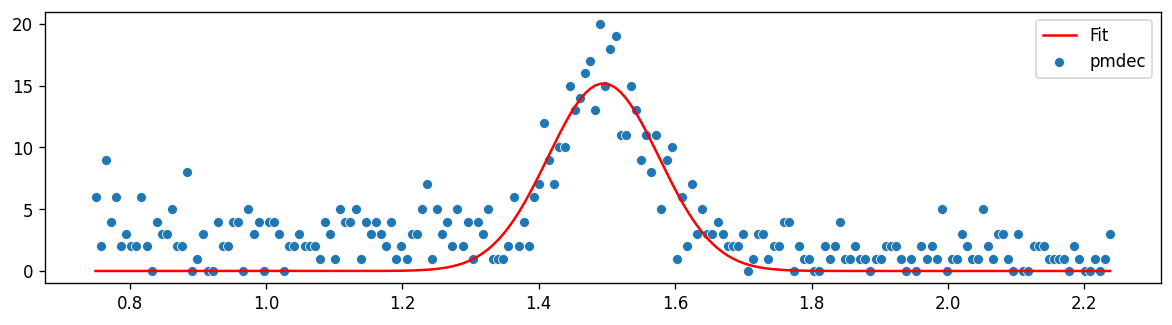

In [59]:
amp, mu, std = fit_curve(df_NGC_4337_new, 'pmdec', bins=200)

In [60]:
df_NGC_4337_new = guassian_filter(df_NGC_4337_new, 'pmdec', mu, std)

upper bound: 1.74
lower bound: 1.25
cluster length: 445


In [50]:
df_NGC_4337_new = df_NGC_4337_new[abs(df_NGC_4337_new['pmra'] + 8.8) < 2]

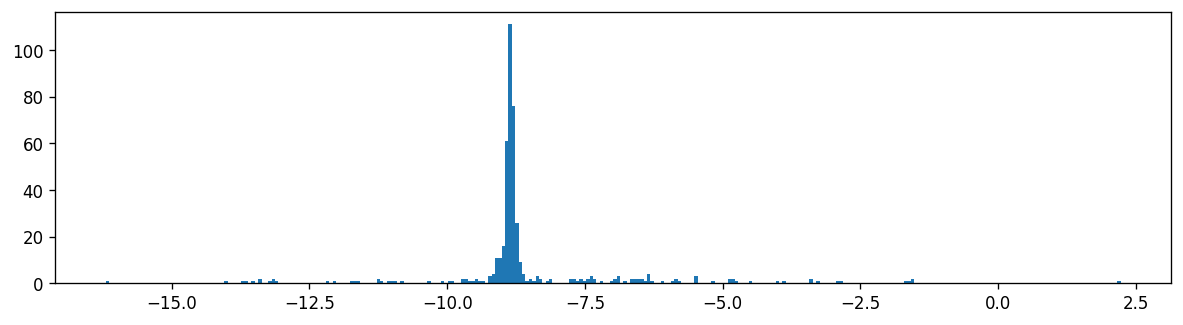

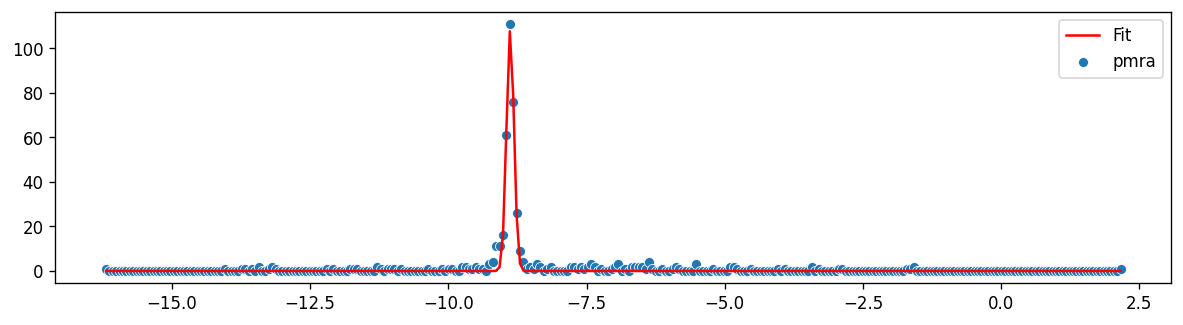

In [61]:
amp, mu, std = fit_curve(df_NGC_4337_new, 'pmra', bins=200)

In [64]:
df_NGC_4337_new = guassian_filter(df_NGC_4337_new, 'pmra', mu, std)

upper bound: -8.68
lower bound: -9.08
cluster length: 308


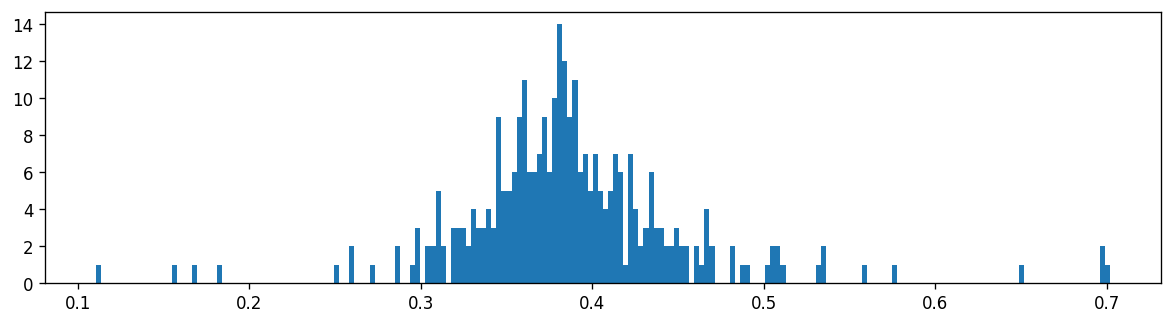

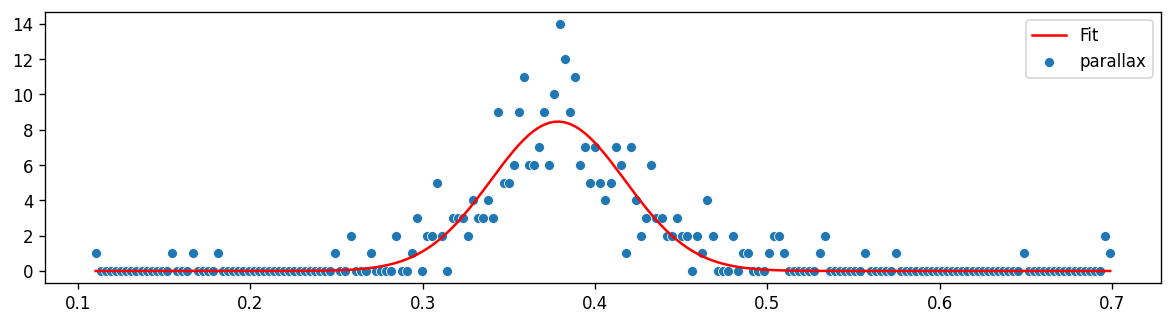

In [65]:
amp, mu, std = fit_curve(df_NGC_4337_new, 'parallax', bins=100)

In [67]:
df_NGC_4337_new = guassian_filter(df_NGC_4337_new, 'parallax', mu, std)

upper bound: 0.5
lower bound: 0.26
cluster length: 286


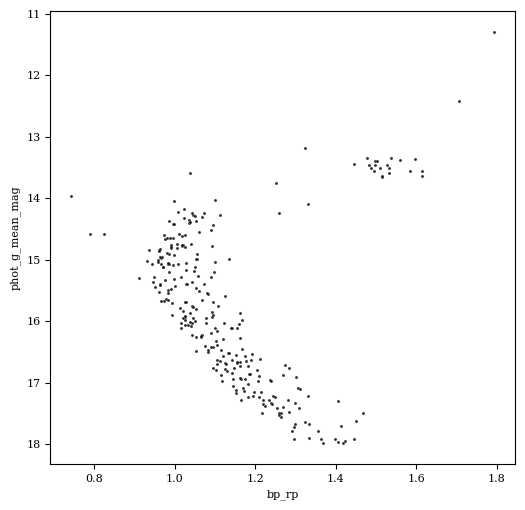

In [76]:
cmd_plot(df_NGC_4337_new, 'bp_rp', 'phot_g_mean_mag')

## 2.1 GMM

In [140]:
gm = GaussianMixture(n_components=2, random_state=101)

y_pred = gm.fit_predict(df_NGC_4337_new[['pmra', 'pmdec', 'parallax']])
y_prob = gm.predict_proba(df_NGC_4337_new[['pmra', 'pmdec', 'parallax']])
df_NGC_4337_new['cluster'] = y_pred
df_NGC_4337_new['prob'] = np.amax(y_prob,axis=1)

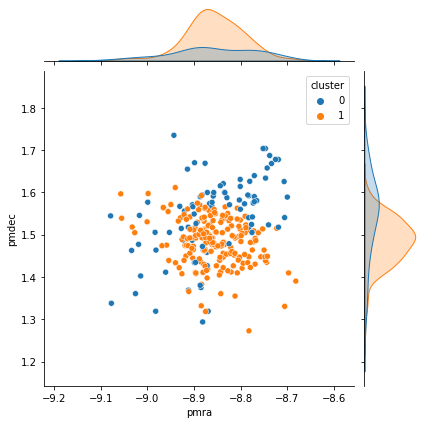

In [141]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_4337_new, kind='scatter', hue='cluster');

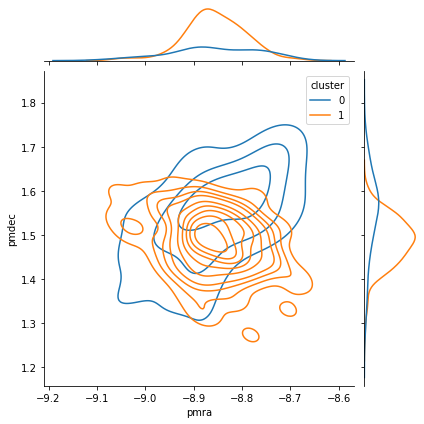

In [142]:
sns.jointplot(x='pmra', y='pmdec',data=df_NGC_4337_new, kind='kde', hue='cluster');

**Note:**

In my opinion all of these stars are cluster stars

---------

# 3 

## CMD plot and g_rp:bp_rp

In [143]:
cluster_NGC_4337 = df_NGC_4337_new[df_NGC_4337_new['cluster']==1]
len(cluster_NGC_4337)

200

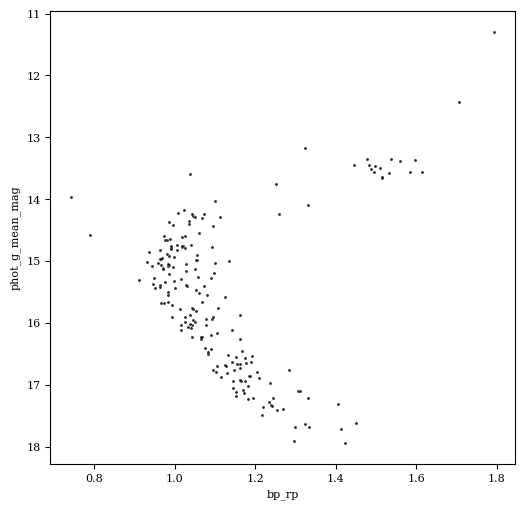

In [144]:
cmd_plot(cluster_NGC_4337, 'bp_rp', 'phot_g_mean_mag')

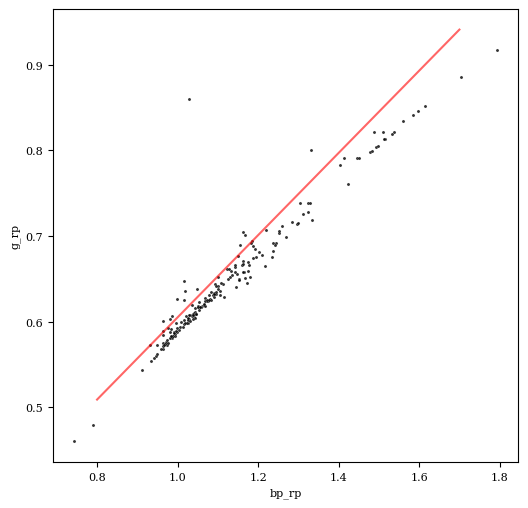

In [145]:
cmd_plot(cluster_NGC_4337, 'bp_rp', 'g_rp')
plt.plot(np.linspace(0.8, 1.7), 0.48 * np.linspace(0.8, 1.7) + 0.125, alpha=0.6, color='red')
plt.gca().invert_yaxis();

<AxesSubplot:xlabel='ra', ylabel='dec'>

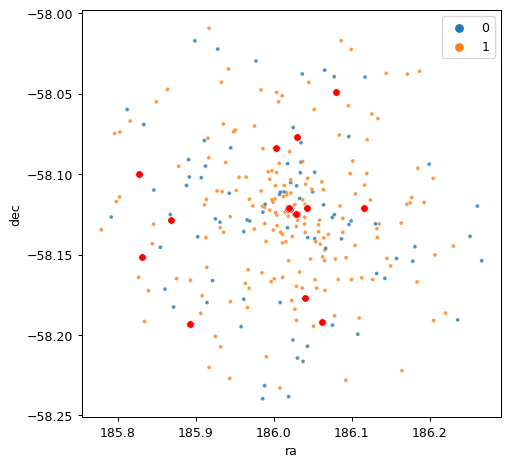

In [146]:
plt.figure(figsize=(6, 6), dpi=90)

sns.scatterplot(data = df_NGC_4337_new, x = 'ra', y='dec', alpha=0.8, s=10, hue='cluster')

sns.scatterplot(data = cluster_NGC_4337[ (( cluster_NGC_4337['bp_rp'] * 0.48) + 0.125 ) < cluster_NGC_4337['g_rp'] ],
                x = 'ra', y = 'dec', color = 'red')

line: `X * 0.48 + 0.12`
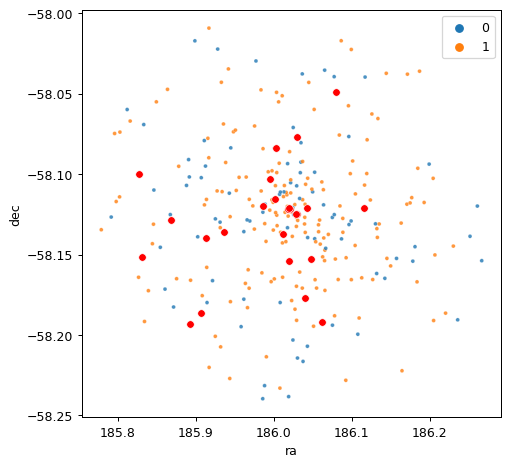

### Number of stars out black body diagram


In [309]:
len(cluster_NGC_4337[ (( cluster_NGC_4337['bp_rp'] * 0.48) + 0.125 ) < cluster_NGC_4337['g_rp'] ])

16

----------------
---------------
----------------
---------------

# Berkeley 58 (250 Myr)

In [257]:
df_Berkeley_58 = pd.read_csv('../../data/Cl Berkeley 58-result.csv')

In [293]:
df_Berkeley_58 = preprocess_cluster(df_Berkeley_58, g_mean_th=18)

1372


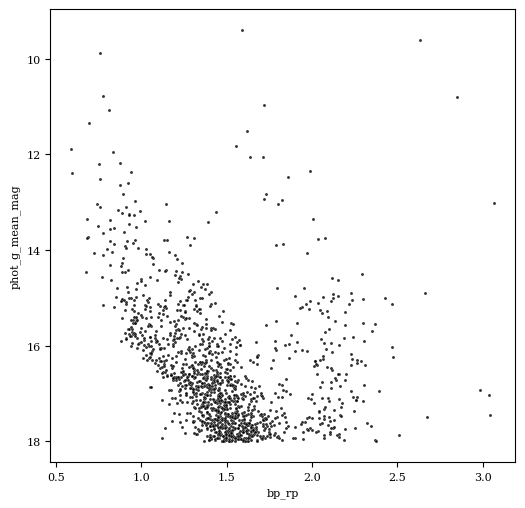

In [294]:
cmd_plot(df_Berkeley_58, 'bp_rp', 'phot_g_mean_mag')

In [295]:
df_Berkeley_58_new = df_Berkeley_58.drop(['phot_variable_flag', 'source_id', 'l', 'b', 'dec_error', 'parallax_error', 
                            'bp_g', 'ra_error', 'radial_velocity', 'radial_velocity_error'],
                          axis=1).dropna(axis=0)
len(df_Berkeley_58_new)

### ra would be 360 and 0 which is bad!!!

df_Berkeley_58_new['ra'] = df_Berkeley_58_new['ra'].apply(lambda ra: ra-360 if ra > 300 else ra)

<Figure size 540x360 with 0 Axes>

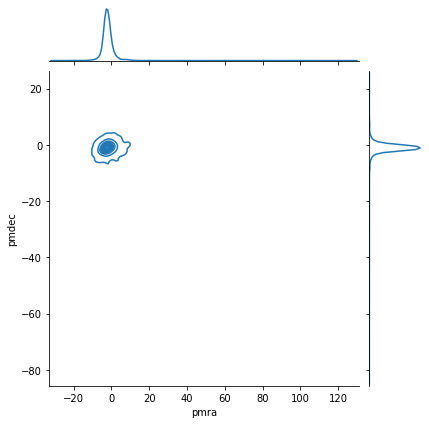

In [261]:
joint_plot(df_Berkeley_58_new)

In [296]:
# Initial Filter on PMRA and PMDEC based on joint plot
df_Berkeley_58_new = df_Berkeley_58_new[abs(df_Berkeley_58_new['pmra']) < 20]
df_Berkeley_58_new = df_Berkeley_58_new[abs(df_Berkeley_58_new['pmdec']) < 20]
len(df_Berkeley_58_new)

1340

<Figure size 540x360 with 0 Axes>

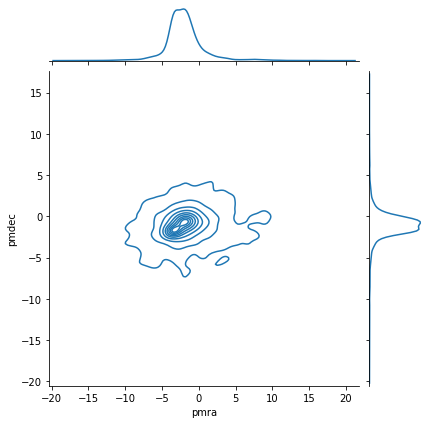

In [263]:
joint_plot(df_Berkeley_58_new)

-----

# 2 

## 2.1 Filters

**Berkeley 58:**

Proper motions mas/yr based on SIMBAD:
```py
    pmra:  -3.498 
    pmdec: -1.782 
    
```

In [297]:
df_Berkeley_58_new = df_Berkeley_58_new[abs(df_Berkeley_58_new['pmra'] + 3.5) < 1]
len(df_Berkeley_58_new)

519

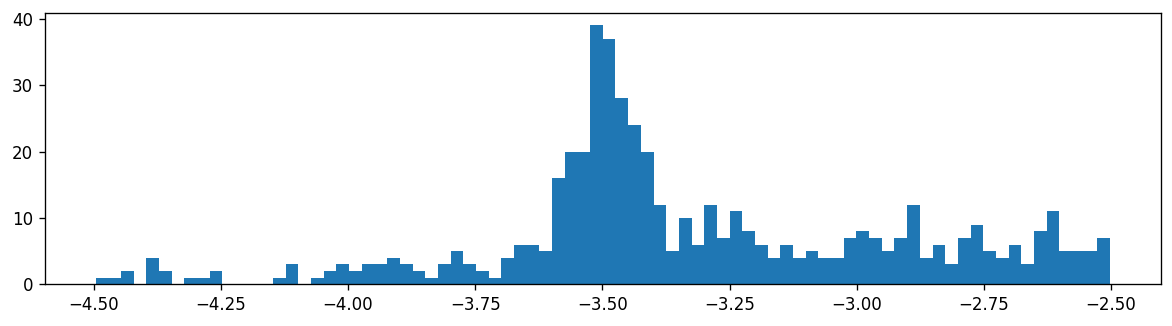

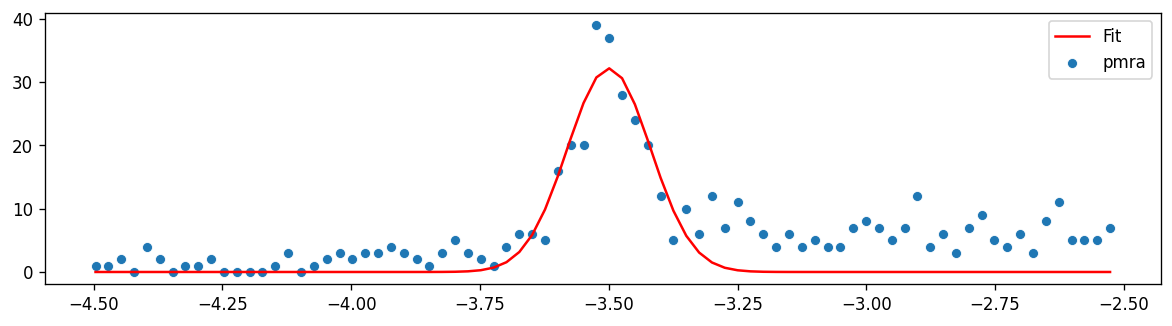

In [298]:
amp, mu, std = fit_curve(df_Berkeley_58_new, 'pmra', bins=80)

In [299]:
df_Berkeley_58_new = guassian_filter(df_Berkeley_58_new, 'pmra', mu, std)

upper bound: -3.26
lower bound: -3.74
cluster length: 275


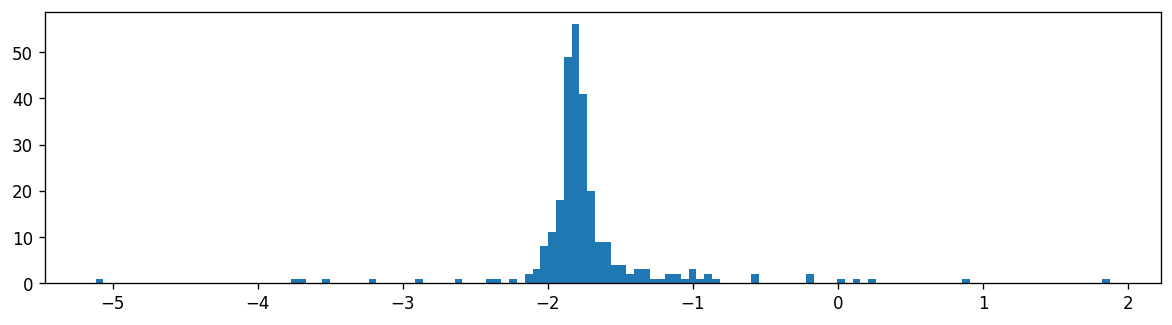

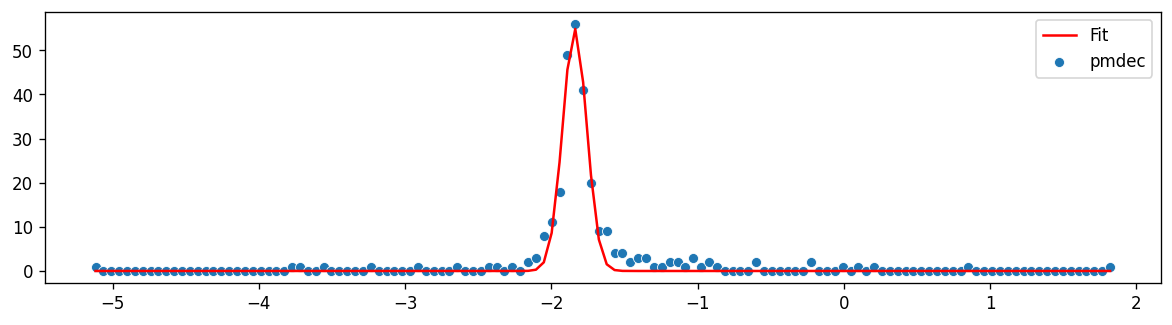

In [300]:
amp, mu, std = fit_curve(df_Berkeley_58_new, 'pmdec', bins=130)

In [301]:
df_Berkeley_58_new = guassian_filter(df_Berkeley_58_new, 'pmdec', mu, std)

upper bound: -1.6
lower bound: -2.09
cluster length: 218


-----

## 2.2 GMM

In [302]:
gm = GaussianMixture(n_components=2, random_state=101)

y_pred = gm.fit_predict(df_Berkeley_58_new[['pmra', 'pmdec',]])
y_prob = gm.predict_proba(df_Berkeley_58_new[['pmra', 'pmdec',]])
df_Berkeley_58_new['cluster'] = y_pred
df_Berkeley_58_new['prob'] = np.amax(y_prob,axis=1)

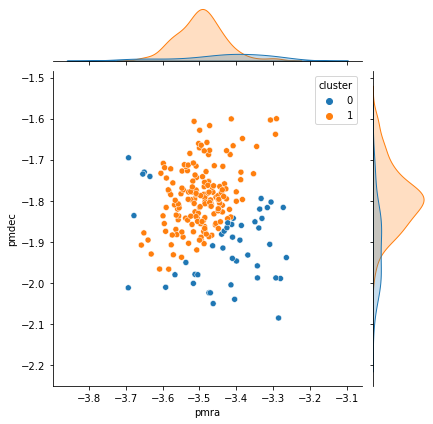

In [303]:
sns.jointplot(x='pmra', y='pmdec',data=df_Berkeley_58_new, kind='scatter', hue='cluster');

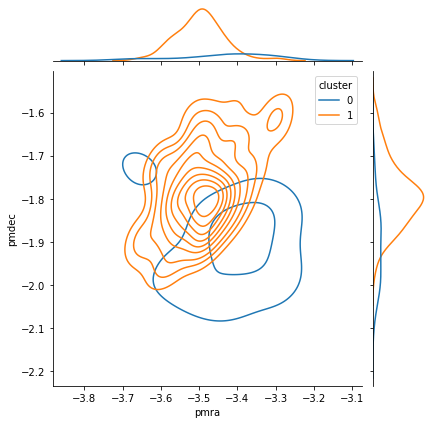

In [304]:
sns.jointplot(x='pmra', y='pmdec',data=df_Berkeley_58_new, kind='kde', hue='cluster');

----
----

# 3 
##  CMD plot and g_rp:bp_rp

In [305]:
cluster_Berkeley_58 = df_Berkeley_58_new[df_Berkeley_58_new['cluster'] == 1]
len(cluster_Berkeley_58)

172

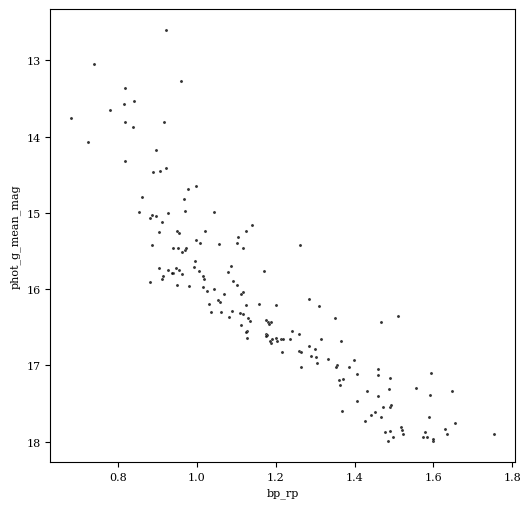

In [306]:
cmd_plot(cluster_Berkeley_58, 'bp_rp', 'phot_g_mean_mag')

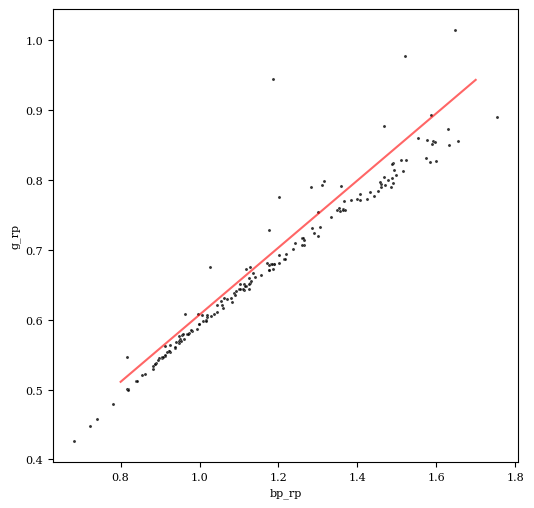

In [307]:
cmd_plot(cluster_Berkeley_58, 'bp_rp', 'g_rp')
plt.plot(np.linspace(0.8, 1.7), 0.48 * np.linspace(0.8, 1.7) + 0.127, alpha=0.6, color='red')
plt.gca().invert_yaxis();

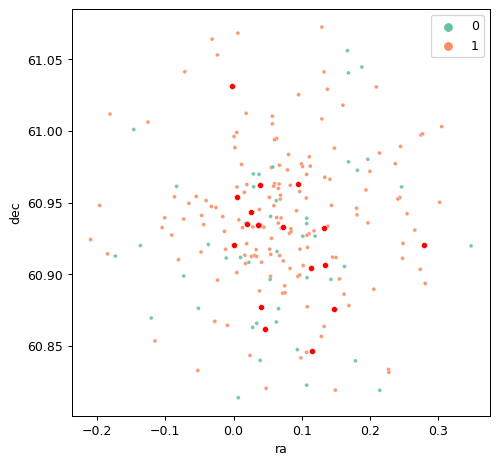

In [322]:
plt.figure(figsize=(6, 6), dpi=90)

sns.scatterplot(data = df_Berkeley_58_new, x = 'ra', y='dec', alpha=0.9, s=10, hue='cluster', palette='Set2')

sns.scatterplot(data = cluster_Berkeley_58[((cluster_Berkeley_58['bp_rp']*0.48) +0.127) < cluster_Berkeley_58['g_rp']],
                s=23, x = 'ra', y = 'dec', color = 'red');

### Number of stars out black body diagram

In [310]:
len(cluster_Berkeley_58[((cluster_Berkeley_58['bp_rp']*0.48) +0.127) < cluster_Berkeley_58['g_rp']])

18